In [1]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 1.2MB 23.2MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [2]:
import torch
import torch.nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

from tqdm import tqdm

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
!python -m spacy download de

     |████████████████████████████████| 14.9MB 19.7MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907057 sha256=9c9dbd43bbe3150538d228337b73284fa2440b4bb4d4eb9435a013a300e03f65
  Stored in directory: /tmp/pip-ephem-wheel-cache-ouleq070/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [5]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [6]:
def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

In [7]:
SRC = Field(
    tokenize = tokenize_en,
    init_token = '<sos>',
    eos_token = '<eos>',
    lower = True,
    include_lengths = True
)

TRG = Field(
    tokenize = tokenize_de,
    init_token = '<sos>',
    eos_token = '<eos>',
    lower = True
)

In [8]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.en', '.de'), fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 865kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 275kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 264kB/s]


In [9]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [10]:
BATCH_SIZE = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort = True,
    sort_key = lambda x: len(x.src)
)

Device: cuda


In [11]:
class Encoder(torch.nn.Module):

  def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
    super().__init__()
    self.embedding = torch.nn.Embedding(input_dim, emb_dim)
    self.rnn = torch.nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
    self.fc = torch.nn.Linear(enc_hid_dim * 2, dec_hid_dim)
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, src, src_len):

    # src -> [src len, batch size]

    embedded = self.dropout(self.embedding(src))
    # embedded -> [src len, batch size, emb_dim]

    packed_embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu())
    packed_outputs, hidden = self.rnn(packed_embedded)
    outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs)
    # outputs -> [src len, batch size, enc_hid_dim * num_directions]
    #         -> [src len, batch size, enc_hid_dim * 2]
    # hidden -> [num_layers * num_directions, batch size, enc_hid_dim]
    #        -> [2, batch size, enc_hid_dim]

    concatenated = torch.cat((hidden[-2, :, :], hidden[-1, :, :]),dim=1)
    # concatenated -> [batch size, enc_hid_dim * 2]

    hidden = torch.tanh(self.fc(concatenated))
    # hidden -> [batch size, dec_hid_him]

    return outputs, hidden

In [12]:
class Attention(torch.nn.Module):

  def __init__(self, enc_hid_dim, dec_hid_dim):
    super().__init__()
    self.attn = torch.nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
    self.v = torch.nn.Linear(dec_hid_dim, 1, bias=False)

  def forward(self, encoder_outputs, hidden, mask):

    # encoder_outputs -> [src len, batch size, enc_hid_dim * 2]
    # hidden -> [batch size, dec_hid_dim]

    src_len = encoder_outputs.shape[0]
    batch_size = encoder_outputs.shape[1]

    # Repeat hidden state for each time step in src len
    hidden = hidden.unsqueeze(0).repeat(src_len, 1, 1)
    # hidden -> [src len, batch size, dec_hid_dim]

    concatenated = torch.cat((encoder_outputs, hidden), dim=2)
    # concatenated -> [src len, batch size, (enc_hid_dim * 2) + dec_hid_dim]

    energy = torch.tanh(self.attn(concatenated))
    # energy -> [src len, batch size, dec_hid_dim]

    attention = self.v(energy).squeeze(2)
    attention = attention.masked_fill(mask == 0, -1e10)
    # attention -> [src len, batch size]

    return F.softmax(attention, dim=0)
    # return dim -> [src len, batch size]
    # the `src len` values of each item in batch add up to 1 (because of softmax)

In [13]:
class Decoder(torch.nn.Module):

  def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
    super().__init__()

    self.output_dim = output_dim

    self.embedding = torch.nn.Embedding(output_dim, emb_dim)
    self.rnn = torch.nn.GRU(emb_dim + (2 * enc_hid_dim), dec_hid_dim)
    self.fc = torch.nn.Linear(emb_dim + dec_hid_dim + (2 * enc_hid_dim), output_dim)
    self.dropout = torch.nn.Dropout(dropout)
    self.attn = attention

  def forward(self, input, encoder_outputs, hidden, mask):
    
    # input -> [batch size]
    # encoder_outputs -> [src len, batch size, enc_hid_dim * 2]
    # hidden -> [batch size, dec_hid_dim]

    input = input.unsqueeze(0)
    # input -> [1, batch size]

    embedded = self.dropout(self.embedding(input))
    # embedded -> [1, batch size, emb_dim]

    a = self.attn(encoder_outputs, hidden, mask)
    # a -> [src len, batch size]

    encoder_outputs = encoder_outputs.permute(1, 0, 2)
    # encoder_outputs -> [batch size, src len, enc_hid_dim * 2]

    a = a.permute(1, 0).unsqueeze(1)
    # a -> [batch size, 1, src len]

    weighted = torch.bmm(a, encoder_outputs).permute(1, 0, 2)
    # weighted -> [1, batch size, enc_hid_dim * 2]

    outputs, hidden = self.rnn(torch.cat((embedded, weighted), dim=2), hidden.unsqueeze(0))
    # outputs -> [1, batch size, dec_hid_dim]
    # hidden -> [1, batch size, dec_hid_dim]

    fc_input = torch.cat((embedded, outputs, weighted), dim=2)
    # fc_input -> [1, batch size, emb_dim + dec_hid_dim + (2 * enc_hid_dim)]

    predictions = self.fc(fc_input).squeeze(0)
    # predictions -> [batch size, output_dim]

    return predictions, hidden.squeeze(0), a.squeeze(1)
    # return dimensions
    # predictions -> [batch size, output_dim]
    # hidden -> [batch size, dec_hid_dim]
    # a -> [batch size, src len]

In [14]:
class Seq2Seq(torch.nn.Module):

  def __init__(self, encoder, decoder, src_pad_idx, device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.device = device

    self.src_pad_idx = src_pad_idx

  def create_mask(self, src):
    mask = (src != self.src_pad_idx)
    # mask -> [src len, batch size]
    return mask

  def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):

    # src -> [src len, batch size]
    # trg -> [trg len, batch size]

    batch_size = trg.shape[1]
    trg_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim

    # decoder outputs
    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

    # pass src through encoder
    encoder_outputs, hidden = self.encoder(src, src_len)
    # encoder_outputs -> [src len, batch size, enc_hid_dim * 2]
    # hidden -> [batch size, dec_hid_him]

    input = trg[0, :]
    # input -> [batch size]

    mask = self.create_mask(src)

    for t in range(1, trg_len):

      output, hidden, attn = self.decoder(input, encoder_outputs, hidden, mask)
      # output -> [batch size, output_dim]
      # hidden -> [batch size, dec_hid_dim]
      # attn -> [batch size, src len]

      outputs[t] = output

      teacher_force = random.random() < teacher_forcing_ratio

      top1 = output.argmax(1)
      # top1 -> [batch size]

      input = trg[t] if teacher_force else top1

    return outputs

In [15]:
def init_weights(m):
  for name, param in m.named_parameters():
    if 'weight' in name:
      torch.nn.init.normal_(param.data, mean=0, std=0.01)
    else:
      torch.nn.init.constant_(param.data, 0)

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [16]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 128
DEC_HID_HIM = 128

DROPOUT = 0.2

src_pad_idx = SRC.vocab.stoi[SRC.pad_token]

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_HIM, DROPOUT)
attn = Attention(ENC_HID_DIM, DEC_HID_HIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_HIM, DROPOUT, attn)

model = Seq2Seq(enc, dec, src_pad_idx, device).to(device)
model.apply(init_weights)

print(f'Model parameters: {count_parameters(model):,}')

Model parameters: 6,267,183


In [17]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5893, 128)
    (rnn): GRU(128, 128, bidirectional=True)
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(7855, 128)
    (rnn): GRU(384, 128)
    (fc): Linear(in_features=512, out_features=7855, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (attn): Attention(
      (attn): Linear(in_features=384, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=False)
    )
  )
)

In [18]:
optimizer = optim.Adam(model.parameters())

In [19]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = torch.nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [20]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in tqdm(enumerate(iterator), total=len(iterator)):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [21]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in tqdm(enumerate(iterator), total=len(iterator)):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [22]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

  1%|          | 1/114 [00:00<00:16,  7.04it/s]

Epoch: 01 | Time: 0m 23s
	Train Loss: 5.964 | Train PPL: 389.324
	 Val. Loss: 5.464 |  Val. PPL: 235.922


  1%|          | 1/114 [00:00<00:15,  7.14it/s]

Epoch: 02 | Time: 0m 23s
	Train Loss: 4.868 | Train PPL: 130.124
	 Val. Loss: 5.551 |  Val. PPL: 257.375


  1%|          | 1/114 [00:00<00:16,  6.99it/s]

Epoch: 03 | Time: 0m 23s
	Train Loss: 4.594 | Train PPL:  98.932
	 Val. Loss: 5.529 |  Val. PPL: 251.824


  1%|          | 1/114 [00:00<00:16,  6.86it/s]

Epoch: 04 | Time: 0m 23s
	Train Loss: 4.429 | Train PPL:  83.876
	 Val. Loss: 5.476 |  Val. PPL: 238.819


  1%|          | 1/114 [00:00<00:16,  7.02it/s]

Epoch: 05 | Time: 0m 23s
	Train Loss: 4.286 | Train PPL:  72.647
	 Val. Loss: 5.497 |  Val. PPL: 243.839


  1%|          | 1/114 [00:00<00:16,  6.92it/s]

Epoch: 06 | Time: 0m 24s
	Train Loss: 4.187 | Train PPL:  65.801
	 Val. Loss: 5.478 |  Val. PPL: 239.317


  1%|          | 1/114 [00:00<00:16,  6.86it/s]

Epoch: 07 | Time: 0m 23s
	Train Loss: 4.067 | Train PPL:  58.393
	 Val. Loss: 5.312 |  Val. PPL: 202.703


  1%|          | 1/114 [00:00<00:16,  6.97it/s]

Epoch: 08 | Time: 0m 23s
	Train Loss: 3.969 | Train PPL:  52.937
	 Val. Loss: 5.150 |  Val. PPL: 172.414


  1%|          | 1/114 [00:00<00:16,  7.03it/s]

Epoch: 09 | Time: 0m 23s
	Train Loss: 3.800 | Train PPL:  44.683
	 Val. Loss: 5.007 |  Val. PPL: 149.512


  1%|          | 1/114 [00:00<00:16,  6.94it/s]

Epoch: 10 | Time: 0m 23s
	Train Loss: 3.648 | Train PPL:  38.394
	 Val. Loss: 4.711 |  Val. PPL: 111.210


  1%|          | 1/114 [00:00<00:16,  7.03it/s]

Epoch: 11 | Time: 0m 23s
	Train Loss: 3.456 | Train PPL:  31.688
	 Val. Loss: 4.467 |  Val. PPL:  87.064


  1%|          | 1/114 [00:00<00:16,  6.96it/s]

Epoch: 12 | Time: 0m 23s
	Train Loss: 3.239 | Train PPL:  25.518
	 Val. Loss: 4.309 |  Val. PPL:  74.400


  1%|          | 1/114 [00:00<00:15,  7.13it/s]

Epoch: 13 | Time: 0m 23s
	Train Loss: 3.057 | Train PPL:  21.257
	 Val. Loss: 4.017 |  Val. PPL:  55.517


  1%|          | 1/114 [00:00<00:16,  6.99it/s]

Epoch: 14 | Time: 0m 23s
	Train Loss: 2.875 | Train PPL:  17.728
	 Val. Loss: 3.942 |  Val. PPL:  51.501


  1%|          | 1/114 [00:00<00:16,  6.98it/s]

Epoch: 15 | Time: 0m 23s
	Train Loss: 2.721 | Train PPL:  15.202
	 Val. Loss: 3.733 |  Val. PPL:  41.803


  1%|          | 1/114 [00:00<00:16,  6.91it/s]

Epoch: 16 | Time: 0m 23s
	Train Loss: 2.595 | Train PPL:  13.397
	 Val. Loss: 3.636 |  Val. PPL:  37.936


  1%|          | 1/114 [00:00<00:16,  6.92it/s]

Epoch: 17 | Time: 0m 23s
	Train Loss: 2.434 | Train PPL:  11.409
	 Val. Loss: 3.546 |  Val. PPL:  34.661


  1%|          | 1/114 [00:00<00:16,  6.85it/s]

Epoch: 18 | Time: 0m 23s
	Train Loss: 2.329 | Train PPL:  10.264
	 Val. Loss: 3.490 |  Val. PPL:  32.771


  1%|          | 1/114 [00:00<00:16,  7.03it/s]

Epoch: 19 | Time: 0m 23s
	Train Loss: 2.239 | Train PPL:   9.383
	 Val. Loss: 3.456 |  Val. PPL:  31.679


100%|██████████| 4/4 [00:00<00:00,  8.29it/s]


Epoch: 20 | Time: 0m 23s
	Train Loss: 2.099 | Train PPL:   8.158
	 Val. Loss: 3.420 |  Val. PPL:  30.567


In [23]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} |  Test PPL: {math.exp(test_loss):7.3f} |')

100%|██████████| 4/4 [00:00<00:00,  9.12it/s]

| Test Loss: 3.396 |  Test PPL:  29.851 |


In [24]:
import matplotlib.pyplot as plt
from matplotlib import ticker

def display_attention(sentence, translation, attention):

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111)

  attention = attention.squeeze(1).cpu().detach().numpy()

  cax = ax.matshow(attention, cmap='bone')

  ax.tick_params(labelsize=15)
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], rotation=45)
  ax.set_yticklabels(['']+translation)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()
  plt.close()

In [25]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):

  model.eval()

  if isinstance(sentence, str):
    nlp = spacy.load('en')
    tokens = [token.text.lower() for token in nlp(sentence)]
  else:
    tokens = [token.lower() for token in sentence]

  tokens = [src_field.init_token] + tokens + [src_field.eos_token]

  src_indexes = [src_field.vocab.stoi[token] for token in tokens]

  src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

  src_len = torch.LongTensor([len(src_indexes)]).to(device)

  with torch.no_grad():
    encoder_outputs, hidden = model.encoder(src_tensor, src_len)

  mask = model.create_mask(src_tensor)

  trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

  attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)

  for i in range(max_len):

    trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

    with torch.no_grad():
      output, hidden, attention = model.decoder(trg_tensor, encoder_outputs, hidden, mask)

      attentions[i] = attention

      pred_token = output.argmax(1).item()

      trg_indexes.append(pred_token)

      if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
        break

  trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

  return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [26]:
def translate_and_display_attention(idx):

  src = vars(train_data.examples[idx])['src']
  trg = vars(train_data.examples[idx])['trg']

  print(f'src: ${src}')
  print(f'trg: ${trg}')

  translation, attention = translate_sentence(src, SRC, TRG, model, device)

  print(f'predicted: {translation}')

  display_attention(src, translation, attention)

src: $['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']
trg: $['ein', 'kleines', 'mädchen', 'klettert', 'in', 'ein', 'spielhaus', 'aus', 'holz', '.']
predicted: ['ein', 'kleines', 'mädchen', 'klettert', 'auf', 'einer', '<unk>', '<unk>', '.', '<eos>']


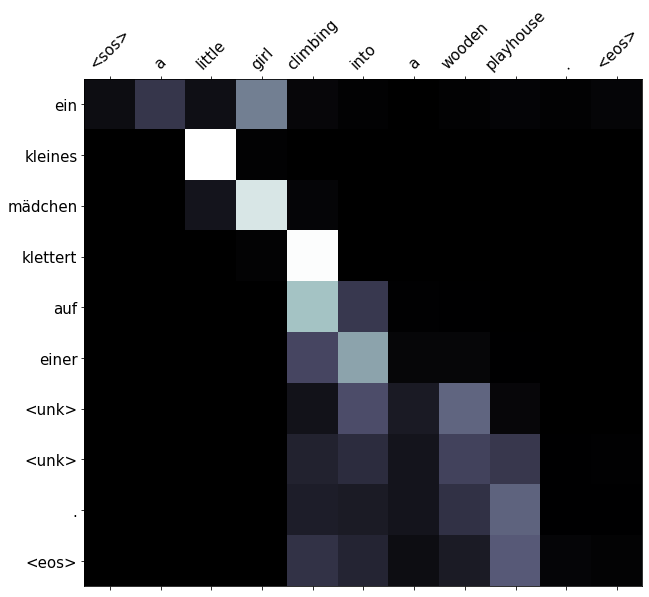

In [27]:
translate_and_display_attention(2)

src: $['toddler', 'boy', 'in', 'a', 'red', 'hat', 'holding', 'on', 'to', 'some', 'railings', '.']
trg: $['männliches', 'kleinkind', 'in', 'einem', 'roten', 'hut', ',', 'das', 'sich', 'an', 'einem', 'geländer', 'festhält', '.']
predicted: ['ein', 'kleiner', 'junge', 'mit', 'einem', 'roten', 'hut', 'hält', 'den', 'kopf', 'auf', 'einem', '<unk>', '.', '<eos>']


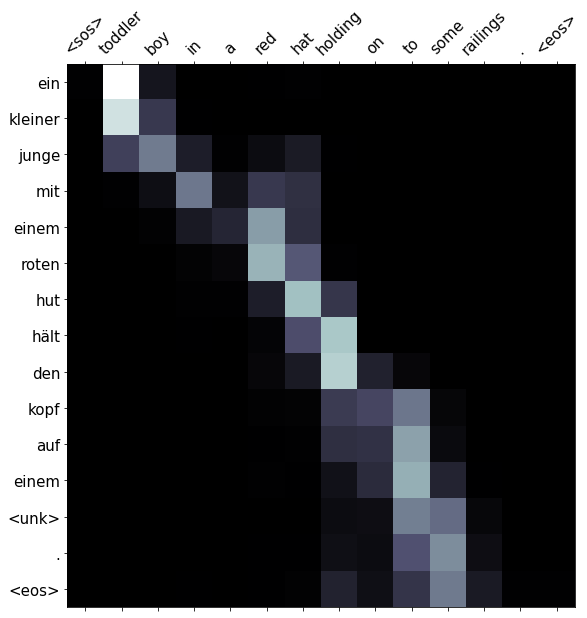

In [28]:
translate_and_display_attention(100)

In [29]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

  trgs = []
  pred_trgs = []

  for datum in data:

    src = vars(datum)['src']
    trg = vars(datum)['trg']

    pred_trg, _ = translate_sentence(src, SRC, TRG, model, device, max_len)

    pred_trg = pred_trg[:-1]

    pred_trgs.append(pred_trg)
    trgs.append([trg])

  return bleu_score(pred_trgs, trgs)

In [30]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 23.84
